In [123]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import cvxpy as cvx
import time






In [124]:
#Cell purpose: defining constants
#I stayed consistent with their notation as opposed to what we used in class

A = np.array([[1, 0.1], [0,1]])
B = np.array([[0],[1]])

Q = np.array([[1, 0], [0, 0.5]])
R = np.array([[1]])

P = scipy.linalg.solve_discrete_are(A, B, Q, R)
K = -np.linalg.inv(R + B.T @ P @ B) @ B.T @ Q @ P @ A
L = A + B@K #true closed loop matrix

T = 30



In [125]:
#Cell purpose: helper functions


#input must be square, symmetric matrix
def svec(a):
    assert a.shape[0] == a.shape[1] and len(a.shape) == 2, "matrix is not square, or it is not 2D. "
    dim = a.shape[0]
    upper_triangular_parts = []
    weight = np.sqrt(2)
    for d in range(dim):
        sliced_row = a[d, d:] 
        sliced_row[1: ] *= weight #scale off-diagonals for consistency with inner product
        upper_triangular_parts.append(sliced_row)
    
    return np.concatenate(upper_triangular_parts)



#n is the dimension of the two square matrices for which we want symm Kron product
def get_U(n): 
    def row_tuple(row, n_rows):
        group_num = 1
        group_size= n
        while row - group_size > 0:
            row -= group_size #trying to find group_num for row
            group_size -= 1 #group size decreases each pass
            group_num += 1 #keep track of group
        return (row ,group_num)
        # adj_row = row + 1
        # group_num = 1
        # group_start = 1
        # group_end = n
        # group_len = n
        # while adj_row > group_end: 
        #     group_len -= 1
        #     group_start = group_end + 1
        #     group_end += group_len
        #     group_num += 1
    
    def col_tuple(col, n_cols):
        idx = col % n
        group = col // n
        return (group+1, idx+1) #adding 1 to be consistent with paper, but should be able to remove later
    n_rows = int((n*(n+1))/2)
    n_cols = int(n**2)
    U = np.zeros((n_rows, n_cols))
    #creating this matrix has a weird form, can't think of a better way to do it than a loop
    c = np.divide(1, np.sqrt(2))
    for row in range(n_rows):
        for col in range(n_cols):
            i, j = row_tuple(row, n_rows)
            k, l = col_tuple(col, n_cols)
            if i==j==k==l:
                U[row,col] = 1
            elif (i==k and j==l) or (i==l and j==k): #didn't pass first branch, so not all equal
                U[row,col] = c
            else:
                U[row,col] = 0
    return U
            
def symm_kron(A, B): 
    U = get_U(A.shape[0])
    return 0.5 * (U @ (np.kron(A, B) + np.kron(B, A)) @ U.T)

def F2_norm(A): 
    return np.sum(np.power(A, 2))
# svec(np.array([[1,2, 3], [1,2,3]])) Throws an error, as is intended

print(get_U(3)) #don't want to write the whole 10 x 9 thing, so check manually

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.70710678 0.         0.70710678 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.70710678 0.         0.         0.
  0.70710678 0.         0.        ]
 [0.         0.70710678 0.         0.70710678 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]]


In [126]:
#Cell purpose: simulation
T=100


# A = np.array([[1, 0.1], [0,1]])
# B = np.array([[0, 0.5],[1, -1]])
# 
# Q = np.array([[1, 0], [0, 0.5]])
# R = np.array([[1, 0], [0, 1]])
# 
# P = scipy.linalg.solve_discrete_are(A, B, Q, R)
# K = -np.linalg.inv(R + B.T @ P @ B) @ B.T @ Q @ P @ A
# L = A + B@K #true closed loop matrix

A = np.array([[1, 0.1], [0,1]])
B = np.array([[0],[1]])

Q = np.array([[1, 0], [0, 0.5]])
R = np.array([[1]])

P = scipy.linalg.solve_discrete_are(A, B, Q, R)
K = -np.linalg.inv(R + B.T @ P @ B) @ B.T @ Q @ P @ A
L = A + B@K #true closed loop matrix

class System:
    
    def __init__(self, x0, A, B, Q, R, P, K, L_star, reg, sigma):
        self.dim = x0.shape[0] #dimension of state space, for now lets say that it's same as action
        self.curr_state = x0
        self.A = A
        self.B = B
        self.Q = Q
        self.R = R
        self.P = P
        self.K = K
        self.reg = reg
        self.sigma = sigma
        self.trajectory = []
        
        self.L_star = L_star
        self.P_star = scipy.linalg.solve_discrete_lyapunov(L_star, Q + K.T @ R @ K)
        
    def reset(self, x0):
        self.trajectory = []
        self.curr_state = x0
        
    def step_system(self): 
        action = self.K @ self.curr_state
        next_state = self.A @ self.curr_state + self.B @ action + self.system_noise(self.sigma)
        self.curr_state = next_state
        return next_state
        
    def system_noise(self, sigma):
      return np.random.normal(scale=sigma, size=(self.dim, 1))
  
    def sim_trajectory(self,T):
        traj = [self.curr_state]
        for _ in range(T):
            next_state = self.step_system()
            traj.append(next_state)                
        traj = np.array(traj)
        self.trajectory = traj
        return traj
    
    def bound(self):
        I = np.eye(self.dim)
        P_inf = scipy.linalg.solve_discrete_lyapunov(self.L_star.T, sigma**2 * I)
        #Should I be using pinv here?
        L_starT = self.L_star.T
        sym = symm_kron(L_starT, L_starT)
        I = np.eye(sym.shape[0])

        term1 = np.linalg.inv(I - sym)
        term2_mat1 = L_starT @ self.P_star @ self.P_star @L_starT
        term2_mat2 = sigma**2 * np.linalg.inv(P_inf)
        term2 = symm_kron(term2_mat1, term2_mat2)
        term3 = term1.T
        
        return 4*np.trace((term1 @ term2 @ term3))
        
    def estimate_L_hat(self, T):
        #TODO: convert to mat mul
        term1 = 0
        term2 = 0
        for t in range(T): 
            term1 += self.trajectory[t+1] @ self.trajectory[t].T
            term2 += self.trajectory[t] @ self.trajectory[t].T
        term2 += self.reg * np.eye(self.dim)
        return term1 @ np.linalg.pinv(term2)
    
    
    def P_plug(self, T):
        return scipy.linalg.solve_discrete_lyapunov(self.estimate_L_hat(T), self.Q + self.K.T @ self.R @ self.K)
        
        



In [138]:
#Cell purpose: main
Ts = [i*10 for i in range(1, 200)]
x0 = np.random.rand(2,1)
sigma = 0.5
reg = 0.1

syst = System(x0, A, B, Q, R, P, K, L, reg, sigma)
risks = []
trajs = []
n_sims = 10
for T in Ts:
    Trisk = 0
    #average over 10 sims
    for i in range(n_sims):
        syst.reset(x0)
        trajs.append(syst.sim_trajectory(T))
        diff = F2_norm(syst.P_star - syst.P_plug(T))
        Trisk += diff
    risks.append(Trisk * T / n_sims)
print(risks)
print(syst.bound())

[3102.369018343526, 20013.9330953357, 15844.058477672395, 2714.592553425727, 7306.740555753395, 1114.2742675762188, 2820.3201715850546, 911.5225380819693, 9635.66677854644, 3994.888591422594, 3591.207300394938, 1922.1406567044833, 5260.311309062244, 6186.956002959539, 6190.451152531851, 5967.9363094733535, 2443.9759606603398, 5071.477700100018, 2927.3272056007218, 4850.453407334429, 2252.1775327477562, 2558.7414118387337, 3432.9966976230803, 2151.4675985389576, 9944.385615754585, 1433.8325953974847, 3926.407974904567, 5593.512622994356, 2902.7514072618446, 2169.1624842330393, 1776.1358062943818, 3103.8730610907837, 1635.022241875392, 1743.9354878260704, 807.2173483115212, 3621.315205916441, 2932.977060771859, 6796.520872637157, 4469.578486029233, 4239.2237113009805, 3920.224420331581, 2757.4694602750355, 3881.865307608731, 5082.222176772708, 3767.1780002740356, 4306.464527539238, 4180.031836057097, 2639.5845881912624, 5829.731257617371, 4475.626119710288, 4673.86872952349, 4612.4931497

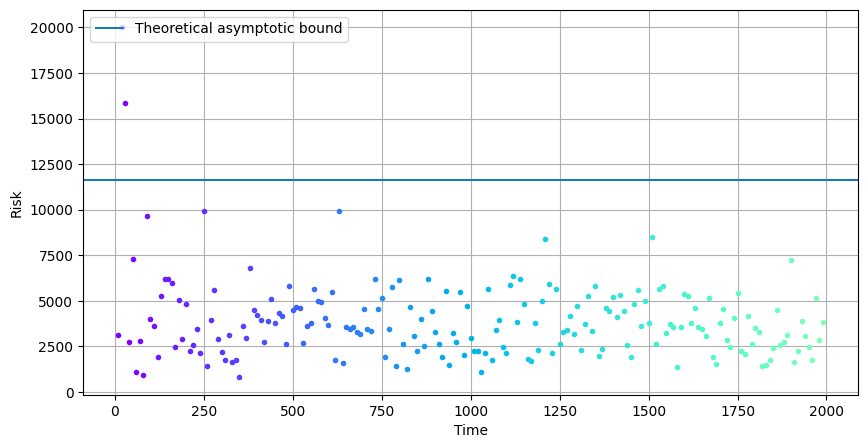

In [139]:
#Cell purpose: plotting

def plot_risks(risks, timesteps, bound):
    colors = iter(plt.cm.rainbow(np.linspace(0, 0.5, len(timesteps))))
    plt.figure(figsize=[10,5])
    for r, t, c in zip(risks, timesteps, colors):
        plt.plot(t, r, '.', color=c)
        plt.plot(t, r, alpha=0.5, color=c)
    plt.axhline(y=bound, label = "Theoretical asymptotic bound")
    plt.legend(loc="upper left")
    plt.xlabel("Time")
    plt.ylabel("Risk")
    plt.grid()

# plot_trajectories(trajs)
plot_risks(risks, Ts, syst.bound())